<a href="https://colab.research.google.com/github/JhonnyLimachi/Sigmoidal/blob/main/36_3_PROJETO_Churn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 4.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [1]:
# instalar Pandas Profiling
!pip install scikit-plot -q
!pip install imbalanced-learn -q

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# random seed
np.random.seed(42)

# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


A visualização das 5 primeiras entradas já permite entender como o dataset está composto. Mesmo que não haja uma definição sobre o significado dos nomes das features, é possível inferir, uma vez que a natureza das empresas de telecomunicações são parecidas.

Como se verifica abaixo, o dataset é composto de 7043 entradas e 21 variáveis.

In [3]:
print("Linhas:\t\t{}".format(df.shape[0]))
print("Colunas:\t{}".format(df.shape[1]))

Linhas:		7043
Colunas:	21


## Análise Exploratória dos Dados

A fim de começar este projeto, irei verificar a integridade e usabilidade do dataset.

Para isso, deixarei impresso a quantidade de dados ausentes, os nomes das colunas, os tipos de variáveis por coluna e os valores únicos por coluna. Essa última, especificamente, vai auxiliar na identificação de variáveis potencialmente categóricas.

In [4]:
print("Dados ausentes (total):\t{}\n".format(df.isnull().sum().values.sum()))
print(df.isnull().sum() / df.shape[0])
print("\nNomes das features:\n{}\n".format(df.columns.values))
print("Valores únicos (por coluna):\n{}\n".format(df.nunique()))
print("Tipos de Variáveis (por coluna)\n{}".format(df.dtypes))

Dados ausentes (total):	0

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

Nomes das features:
['customerID' 'gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure'
 'PhoneService' 'MultipleLines' 'InternetService' 'OnlineSecurity'
 'OnlineBackup' 'DeviceProtection' 'TechSupport' 'StreamingTV'
 'StreamingMovies' 'Contract' 'PaperlessBilling' 'PaymentMethod'
 'MonthlyCharges' 'TotalCharges' 'Churn']

Valores únicos (por coluna):
customerID          7043
gender                 2
SeniorCitizen          2
Partner             

Veja algumas observações que merecem destaque, observadas nessa fase inicial de awareness:

* A coluna `costumerID` não agrega nenhuma informação, pois se trata de um identificador única para cada cliente.
* A variável alvo está na coluna `Churn`, indicando a situação de churn.
* A coluna `TotalCharges` deveria ser um `float`, mas está como `string`.
    * Como iremos ver mais à frente, apesar de não termos detectado nenhum valor ausente, existem algumas strings que representam sim valores ausentes.
* Várias features precisam ser codificadas para valores numéricos.
    * Há várias features binárias, incluindo nossa variável alvo, ou com múltiplos valores, cada um representando uma categoria.

Retornando à situação de dados ausentes na coluna `TotalCharges`, veja como foi possível identificar (explicado no vídeo da aula).

In [5]:
# EXEMPLO DE DADOS QUE PRECISAM SER TRABALHADOS

# converter coluna TotalCharges para float
# df["TotalCharges"].astype('float32')

Quando tentamos converter as strings da coluna `TotalCharges`, acabamos identificando um erro.

O que aconteceu na verdade, foi que os supostos dados ausentes foram lançados como a string `""`. Quando tentamos `float("")`, o interpretador retorna um erro.

Assim, para conseguri converter adequadamente, criei uma função para ldiar com essa exceção. Ao final, identifiquei que dados ausentes foram encontrados, e substitui pelo valor da mediana da coluna.

Abaixo, também já aproveitei e excluí a coluna `customerID`, que seria desnecessária ao longo de todo este projeto.

In [6]:
def converter_str_float(entrada):
    """
    Converte um objeto do tipo string em float.

    # Arguments
        entrada: string, string da coluna TotalCharges.

    # Returns
        Valor convertido em float, caso permita a conversão.
        NaN, caso o valor não seja apropriado.
    """

    try:
        return float(entrada)
    except ValueError:
        return np.nan

# criar cópia do dataframe
df_clean = df.copy()

# remover coluna costumerID
df_clean.drop("customerID", axis=1, inplace=True)

# converter as strings de TotalCharges para float
df_clean["TotalCharges"] = df_clean["TotalCharges"].apply(converter_str_float)

# verificar entradas ausentes
print("Dados ausentes em 'TotalCharges' (antes):\t{}\n".format(df_clean["TotalCharges"].isnull().sum()))

# substituir os dados ausentes pelo valor da mediana
TotalChargesMedian = df_clean.TotalCharges.median()
df_clean["TotalCharges"].fillna(TotalChargesMedian, inplace=True)

Dados ausentes em 'TotalCharges' (antes):	11



Apesar deste dataset ser composto majoritariamente por variáveis binárias ou categóricas, é possível ver abaixio, pelo método `describe`, que não há indícios da presença de outliers.

In [7]:
df_clean.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Analisando o boxplot para as colunas `MonthlyCharges` e `TotalCharges`, perceba como a distribuição dos valores reforça essa hipótese. O threshold padrão não acusou nenhum plot fora dos limites superior e inferior.

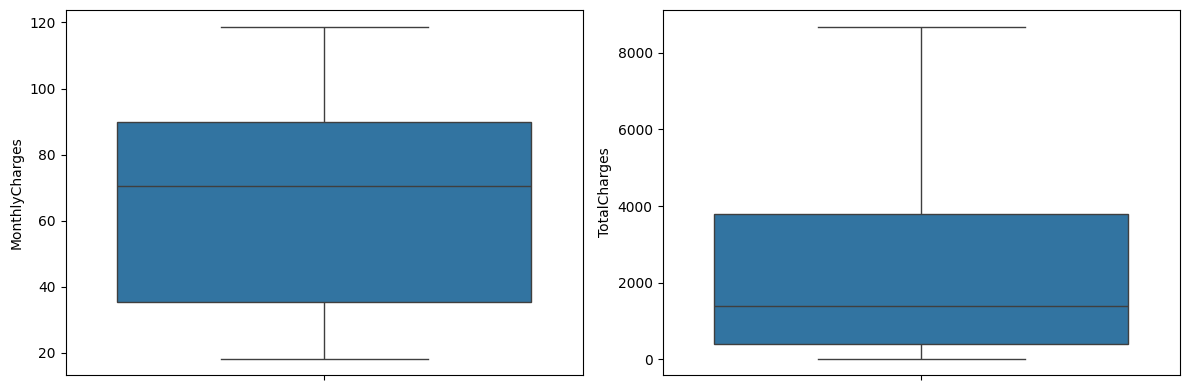

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.boxplot(df_clean['MonthlyCharges'], ax=ax[0])
sns.boxplot(df_clean['TotalCharges'], ax=ax[1])
plt.tight_layout()

A variável `tenure` está relacionada ao tempo que um cliente permance assinando determinado serviço. Em outras palavras, pode-se dizer que é um indicativo de fidelidade.

Apesar de não haver nenhuma documentação, assumo que a unidade de tempo utilizada é "mês".

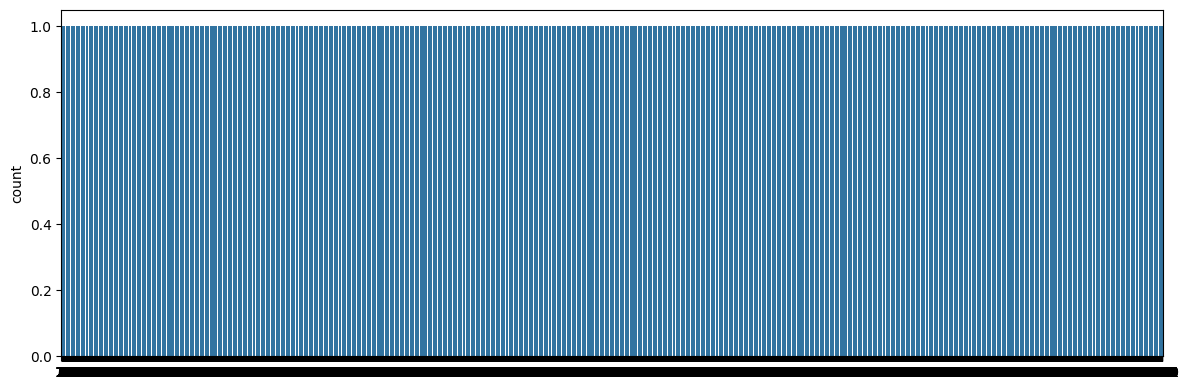

In [9]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.countplot(df['tenure'])
plt.tight_layout()

Lidando com variáveis categóricas, é importante ver os valores únicos. Isso permite identificar situações como labels diferentes querendo indicar a mesma coisa.

Vendo os valores impressos na célula abaixo, entendo que um cientista de dados pode queer considerar valores como `No`, `No phone service` e `No internet service` como sendo a mesma coisa.

Apesar de totalmente válida, não será essa a premissa adotada aqui. Irei considerar cada label individualmente.

In [10]:
# verificar valores únicos das variáveis categóricas
np.unique(df_clean.select_dtypes('object').values)

array(['Bank transfer (automatic)', 'Credit card (automatic)', 'DSL',
       'Electronic check', 'Female', 'Fiber optic', 'Mailed check',
       'Male', 'Month-to-month', 'No', 'No internet service',
       'No phone service', 'One year', 'Two year', 'Yes'], dtype=object)

Para identificar se os nossos dados podem estar com algum tipo de bias (viés), irei verificar a contagem de valores para `Male` e `Female`.

Apesar de não entender que isso poderia gerar algum prejuízo relevante neste problema específico, haverá muitas situações onde esse prejuízo será real, como é o caso de modelos aplicados à contratação de funcionários ou previsão de crimes.

Abaixo, você pode ver que o gênero das entradas está balanceado.

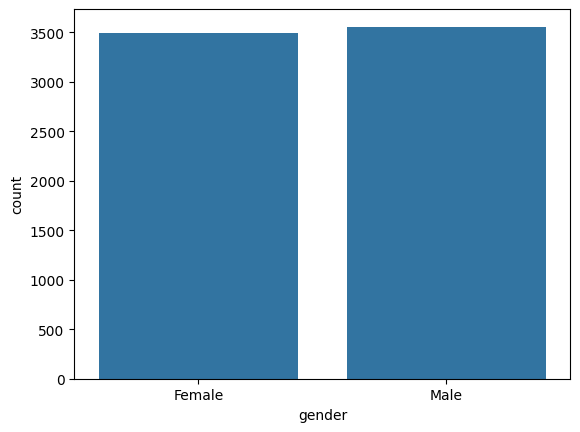

In [11]:
sns.countplot(data=df, x='gender');

Por fim, nesta primeira análise exploratória, vamos ver o balanceamento das classes do dataset.

É possível identificar que a classe `No` ocorre com frequência muito superior à classe `Yes`. Isso será considerado na etapa de construção do modelo de machine learning.

<Axes: xlabel='Churn', ylabel='count'>

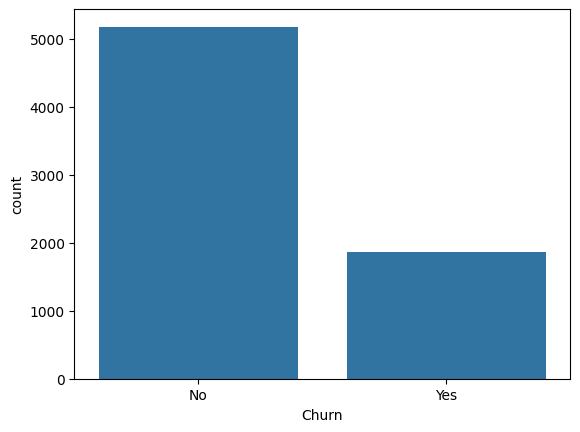

In [12]:
sns.countplot(data=df, x='Churn')

## Preparar os Dados

Nesta etapa de preparação dos dados, será realizado um pré-processamento básico, apenas com a finalidade de construir um modelo base.

As features que continham 2 labels únicos, serão processadas usando-se o `LabelEncoder`. Vale lembrar que isso inclui a variável alvo `Churn`. Na sequência, serão separadas as variáveis numéricas das categóricas. As categóricas serão transformadas em variáveis dummy, para permitir a sua utilização em todos os modelos.

In [13]:
# pré processar as variáveis
binary_var = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
num_var = [col for col in df_clean.select_dtypes(['int', 'float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_clean.columns.tolist() if col not in binary_var + num_var]

# criar uma cópia do dataframe
df_proc = df_clean.copy()

# Label Encoding para as variáveis Binárias
le = LabelEncoder()
for i in binary_var:
    df_proc[i] = le.fit_transform(df_proc[i])

# Encoding para colunas categóricas com múltiplas classes
df_proc = pd.get_dummies(df_proc, columns=cat_var)

# ver as 5 primeiras entradas do novo dataframe
df_proc.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,True,False,False,True,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,True,False,False,False,True,False,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,...,True,False,False,True,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,True,False,False,False,True,False,True,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,...,True,False,False,True,False,False,False,False,True,False


## Modelo de Machine Learning

Com o processamento realizado na etapa anterior, os dados já podem ser usados nos modelos de machine learning.

Para podermos comparar o desempenho e melhora do modelo, criaremos um baseline simples. Não será feito nenhum ajuste nos hiperparâmetros e nem será pensado ainda em balanceamento de dados, feature engineering ou feature selection (entre outros).

No entanto, desde já é importante separar os dados que serão utilizados como treino e como teste. Os dados de teste só irão ser usados na última etapa do projeto, para termos uma avaliação mais real.

In [14]:
# separar a feature matrix da target vector
X = df_proc.drop('Churn', axis=1)
y = df_proc['Churn']

# dividir os dados entre treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y)

Irei usar a cross-validation para estimar o erro da baseline e dos modelos iniciais. Para facilitar e melhorar o código, foi criada uma função `val_model`. A métrica utilizada para avaliação será `recall`.

In [15]:
def val_model(X, y, clf, quite=False):
    """
    Realiza cross-validation com os dados de treino para determinado modelo.

    # Arguments
        X: DataFrame, contém as variáveis independetes.
        y: Series, vetor contendo a variável alvo.
        clf: modelo classificador do Scikit-learn.
        quite: bool, indicando se a função deve imprimir os resultados ou não.

    # Returns
        float, média dos scores da cross-validation.
    """

    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if quite == False:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))

    return scores.mean()

Para o baseline inicial, usarei o Random Forest, sem nenhum tipo de alteração nos parâmetros. Os dados que serão passados são os de treino.

In [16]:
# criar baseline e ver desempenho
rf = RandomForestClassifier()
score_baseline = val_model(X_train, y_train, rf)

Recall: 0.47 (+/- 0.02)


Uma vez que temos um baseline para comparar se os ajustes melhoram ou pioram o desempenho do modelo, irei realizar o balanceamento dos dados e ver como isso irá impactar.

A técnica escolhida foi Under Sampling, após alguns teste de desempenho das outras. Seguindo recomendações de algumas literaturas, os dados serão padronizados antes de usar essa técnica de balanceamento.

Lembrando, é importante que o balanceamento aconteca apenas com os dados de treino. Os dados de teste devem permanecer intocáveis.


In [17]:
#  padronizar os  dados,
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Para quem quiser, pesquisa sobre SMOTE
# oversample = SMOTE()
# X_train, y_train = oversample.fit_sample(X_train, y_train)

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

Irei aplicar a validação cruzada a vários modelos, a fim de identificar o seu desempenho e escolher o(s) melhor(es). Novamente, serão utilizados apenas dados de treino. Os modelos escolhidos são:

* Random Forest
* Decision Tree
* Stochastic Gradient Descent
* SVC
* Regressão Logística
* LightGBM



In [18]:
# instanciar modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
recall = []
# avaliar o desempenho (recall)
for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, quite=True))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

[LightGBM] [Info] Number of positive: 1112, number of negative: 1112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1112, number of negative: 1112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[L

,Recall
RandomForestClassifier,0.769784
DecisionTreeClassifier,0.681295
SGDClassifier,0.733813
SVC,0.790647
LogisticRegression,0.807194
XGBClassifier,0.739568
LGBMClassifier,0.772662


Dadas as características do problema e o desempenho durante as execuções anteriores, optei pelo XGBoost, praticamente empatado com a Regressão Logística.

Meu entendimento é que o tuning dos parâmetros pode melhorar ainda mais a qualidade da solução. Como temos poucos ajustes possíveis na Regressão Logística, não acredito que o resultado poderia passar o XGBoost.

## Otimização dos Hiperparâmetros

XGBoost possui inúmeros parâmetros. Alguns afetam mais a qualidade do modelo, outros menos. Uma boa prática é definir uma taxa de aprendizado e número de estimadores, realizar tuning de outros parâmetros e, no final, checar outras taxas de aprendizado.

Abaixo, irei ajustar o número de estimadores. O modelo foi instanciado com a `learning_rate=0.1`.